In [10]:
import matplotlib.pyplot as plt
import torchvision
from pathlib import Path
import torch

from torch import nn
from torchvision import transforms
from scripts import data_setup, engine
import torchinfo


In [11]:
#VGG16, GoogLenet, ResNet, ResNeXt, efficientnet and DenseNet are the architectures

In [12]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [13]:
data_path = Path("data/")
image_path = data_path / "soil_low_med_high"

In [14]:
# Get a set of pretrained model weights
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # .DEFAULT = best available weights from pretraining on ImageNet
weights
# Get the transforms used to create our pretrained weights
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [15]:
# Setup Dirs
train_dir = image_path / "train"
test_dir = image_path / "test"

In [16]:
# Create training and testing DataLoaders as well as get a list of class names
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=auto_transforms, # perform same data transforms on our own data as the pretrained model
                                                                               batch_size=5) # set mini-batch size to 32

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x1d1fbd2a450>,
 ['high', 'low', 'medium'])

In [17]:
# OLD: Setup the model with pretrained weights and send it to the target device (this was prior to torchvision v0.13)
# model = torchvision.models.efficientnet_b0(pretrained=True).to(device) # OLD method (with pretrained=True)

# NEW: Setup the model with pretrained weights and send it to the target device (torchvision v0.13+)
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # .DEFAULT = best available weights 
model = torchvision.models.efficientnet_b0(weights=weights).to(device)

#model # uncomment to output (it's very long)

In [18]:
# Print a summary using torchinfo (uncomment for actual output)
torchinfo.summary(model=model, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
) 

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

In [19]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in model.features.parameters():
    param.requires_grad = False

In [20]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True), 
    nn.Linear(in_features=1280, 
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)

In [22]:
# # Do a summary *after* freezing the features and changing the output classifier layer (uncomment for actual output)
torchinfo.summary(model, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

In [23]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [24]:
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Setup training and save the results
results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=9,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

 11%|█         | 1/9 [00:20<02:46, 20.81s/it]

Epoch: 1 | train_loss: 1.0210 | train_acc: 0.4556 | test_loss: 0.9874 | test_acc: 0.4000


 22%|██▏       | 2/9 [00:41<02:23, 20.45s/it]

Epoch: 2 | train_loss: 0.9582 | train_acc: 0.5778 | test_loss: 0.9290 | test_acc: 0.5200


 33%|███▎      | 3/9 [00:59<01:58, 19.67s/it]

Epoch: 3 | train_loss: 0.8495 | train_acc: 0.6778 | test_loss: 0.8766 | test_acc: 0.6000


 44%|████▍     | 4/9 [01:19<01:37, 19.52s/it]

Epoch: 4 | train_loss: 0.8069 | train_acc: 0.6222 | test_loss: 0.9762 | test_acc: 0.5200


 56%|█████▌    | 5/9 [01:38<01:18, 19.60s/it]

Epoch: 5 | train_loss: 0.7176 | train_acc: 0.8000 | test_loss: 0.8195 | test_acc: 0.7600


 67%|██████▋   | 6/9 [01:58<00:59, 19.75s/it]

Epoch: 6 | train_loss: 0.7255 | train_acc: 0.7111 | test_loss: 3.0744 | test_acc: 0.7200


 78%|███████▊  | 7/9 [02:19<00:39, 19.91s/it]

Epoch: 7 | train_loss: 0.7018 | train_acc: 0.7000 | test_loss: 0.7793 | test_acc: 0.7600


 89%|████████▉ | 8/9 [02:41<00:20, 20.75s/it]

Epoch: 8 | train_loss: 0.5910 | train_acc: 0.7444 | test_loss: 1.7275 | test_acc: 0.7600


100%|██████████| 9/9 [03:01<00:00, 20.13s/it]

Epoch: 9 | train_loss: 0.7165 | train_acc: 0.7333 | test_loss: 0.7032 | test_acc: 0.7200
[INFO] Total training time: 181.150 seconds


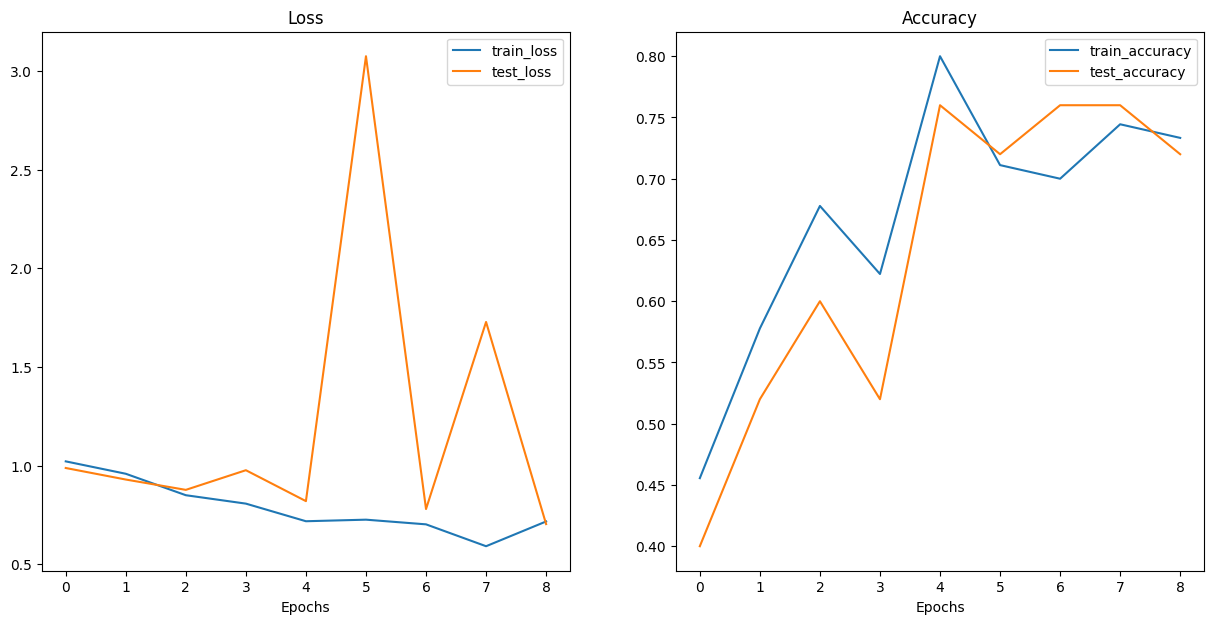

In [25]:
from helper_functions import plot_loss_curves

plot_loss_curves(results)